### Walk through of CoInD using a 2D gaussian example

In [1]:
import sys
import os
parent_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(parent_dir)

import torch
import pytorch_lightning as pl
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from matplotlib import cm
from typing import Optional
import functools
import seaborn as sns
import math
from diffusers import DDPMScheduler


torch.manual_seed(42)
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'  # Use GPU 1
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')


### Gaussian Dataset

(-2.5, 2.5)

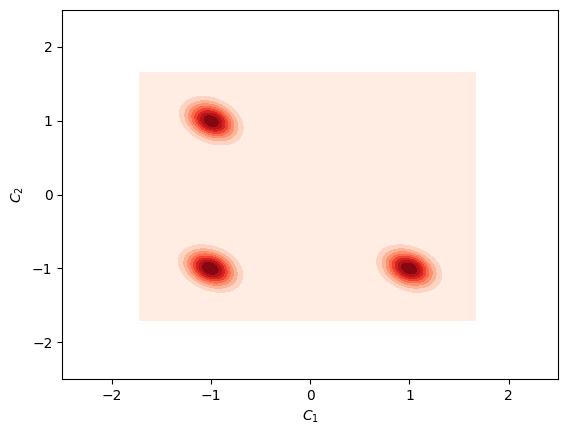

In [74]:
class IndpGaussianDataset(Dataset):
    def __init__(self,data_size:int =200,mode: str = 'train'):
        self.data,self.y = self.inf_train_gen(data_size,mode)
    def inf_train_gen(self,batch_size,mode):
        #normal at (-1,-1), (-1,1), (1,-1), (1,1)
        if mode == 'train':
            xy = torch.tensor([(-1,-1), (-1,1), (1,-1)])
        else:
            xy = torch.tensor([(-1,-1), (-1,1), (1,-1), (1,1)])
        y = torch.randint(len(xy), (batch_size,))
        data = xy[y] + torch.randn(batch_size, 2)*0.1
        y = (xy[y]/2+1.5).to(torch.long)
        return data.float(),y
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):  
        return {
                'X': self.data[idx],
                'label': self.y[idx],
                'label_null': torch.zeros_like(self.y[idx])
            }
#plot dataset
def density_plot(samples):
    sns.kdeplot(x=samples[:,0], y=samples[:,1], cmap="Reds", fill=True, thresh=0, bw_adjust=0.5)
    
dataset = IndpGaussianDataset(4096)
#plot dataset
density_plot(dataset.data)
plt.xlabel(r"$C_1$")
plt.ylabel(r"$C_2$")

### Train Diffusion model with Conditional Independence

2D conditional noise prediction model: 
- SinusoidalPositionEmbeddings time embeddings
- nn.Embedding for labels encoding
- MLP which takes array of the labels encodings, time embeddings, input (X)

In [75]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1,y_dims:list[int]=[], hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.ModuleList([nn.Embedding(y_dims[i], input_dim,dtype=torch.float32) for i in range(len(y_dims))])
        self.time_embedding  = SinusoidalPositionEmbeddings(input_dim*2)
        
        self.y_dim = len(y_dims)*input_dim
        self.main = nn.Sequential(
            nn.Linear(input_dim+input_dim*2+self.y_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
            )

    def forward(self, x: Tensor, t: Tensor,y:Optional[Tensor]=None) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = self.time_embedding(t)
        if y is not None:
            y = torch.cat([self.embedding[i](y[:,i]) for i in range(y.shape[1])], dim=1)
            h = torch.cat([x, t, y], dim=1)
        else:
            h = torch.cat([x, t], dim=1)
        output = self.main(h)
        return output.reshape(*sz)


Train_step consits of the diffusion model with the CoInD loss mentioned in the paper.

Conditional independence $C_1 \perp\perp C_2 \mid X$, where $C_1$ is obtained replacing all the other $C_i$ with respective null token ($\varnothing$), which is performed in prepare_labels function

CoInD loss is given by: $|| \epsilon_{\theta}(x_t,t,(c_1,\varnothing)) +\epsilon_{\theta}(x_t,t,(c_2,\varnothing)) - \epsilon_{\theta}(x_t,t,(c_1,c_2)) - \epsilon_{\theta}(x_t,t,(\varnothing,\varnothing))||_2^2 $

In [76]:
def prepare_labels(y,y_null):
    # prepare labels for diffusion and conditional independence.
    p_null = 0.2
    y_diffusion_obj = torch.where(torch.rand(y.size(0),1,device=y.device) < p_null , y_null, y)
    #y_diffusion_obj = torch.where(torch.rand(*y.shape,device=y.device) < p_null , y_null, y)
    batch_size, num_cols = y.size()

    all_y_idx = torch.arange(num_cols).repeat(batch_size,1)
    y_indices = torch.argsort(torch.rand(*all_y_idx.shape[:2]), dim=1)
    y_idx = torch.gather(all_y_idx, dim=-1, index=y_indices)[:,:2]
    x_idx = torch.arange(batch_size*4)
    y_null = y_null.repeat(2,1)
    y_coind_obj = y.clone().repeat(4,1)
    y_coind_obj[x_idx[:batch_size],y_idx[:batch_size,0]] = y_null[x_idx[:batch_size],y_idx[:batch_size,0]]
    y_coind_obj[x_idx[batch_size:batch_size*3],:] = y_null[x_idx[:batch_size*2],:]
    y_coind_obj[x_idx[batch_size:batch_size*2],y_idx[:batch_size,0]] = y[x_idx[:batch_size],y_idx[:batch_size,0]]
    return y_diffusion_obj,y_coind_obj


def train_step(batch,model,noise_scheduler,lambda_coind):
    #diffusion model training with conditional independence
    x0,y,y_null = batch['X'].to(device),batch['label'].to(device),batch['label_null'].to(device)
    y_diffusion_obj,y_coind_obj = prepare_labels(y,y_null)
    noise = torch.randn_like(x0)
    batch_size, num_cols = y.size()
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps,
                                (batch_size,),device=device).long()
    xt = noise_scheduler.add_noise(x0, noise, timesteps)
    noise_pred = model(xt, timesteps,y_diffusion_obj)
    l_diffusion  = F.mse_loss(noise_pred, noise)

    if lambda_coind > 0.0:   
        xt = xt.repeat(4,1,1,1)
        timesteps = timesteps.repeat(4) 
        noise_pred_new = model(xt, timesteps,y_coind_obj).chunk(4,dim=0)
        l_coind = F.mse_loss(noise_pred_new[0]+noise_pred_new[1], noise_pred_new[2]+noise_pred_new[3])
        l = l_diffusion + lambda_coind*l_coind
    else:
        l = l_diffusion
    return l

## Training Diffusion models with CoInD

In [77]:
import torch
import torch.nn.functional as F
import numpy as np

lr = 1e-3
data_size = 4096
iterations = 5001
hidden_dim = 256
lambda_coind = 1.0
print_every = 1000

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, prediction_type="epsilon", beta_schedule="linear")
epsilon_network = MLP(input_dim=2, time_dim=1,y_dims=[3,3], hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.AdamW(epsilon_network.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)
train_dataloader = DataLoader(dataset, batch_size=data_size, shuffle=True)

for i in range(iterations):
    for batch in train_dataloader:
        loss = train_step(batch,epsilon_network,noise_scheduler,lambda_coind)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    if i % print_every == 0:
        print(f"Step {i}, Loss: {loss.item()}")

/research/hal-gaudisac/miniconda3/envs/compositional-generation/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Step 0, Loss: 1.0162663459777832
Step 1000, Loss: 0.07252735644578934
Step 2000, Loss: 0.06941553950309753
Step 3000, Loss: 0.05987977981567383
Step 4000, Loss: 0.0671032965183258
Step 5000, Loss: 0.06109536439180374


#### Sample from trained model using Classifier free guidance, AND compositionality

In [78]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

class ANDGuidance(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        y_phi = extras['y_null']
        y_10,y_01 = extras['y'].clone(),extras['y'].clone()
        y_10[:,1],y_01[:,0] = y_phi[:,1],y_phi[:,0]
        w1, w2 = 6.0, 6.0
        if 'w' in extras:
            w1, w2 = extras['w']
        result =(self.model(x, t,y_phi))*(1-w1-w2) + w1*self.model(x, t,y_01) + w2*self.model(x, t,y_10)
        return result

class ClassifierFreeGuidance(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        y,y_phi = extras['y'],extras['y_null'] 
        w = 6.0
        if 'w' in extras:
            w = extras['w']
        result =(self.model(x, t,y_phi))*(1-w) + w*self.model(x, t,y)
        return result

epsilon_network.eval()
epsilon_network.to(device)
and_model = ANDGuidance(epsilon_network)
cfg_model = ClassifierFreeGuidance(epsilon_network)

Text(0, 0.5, '$C_2$')

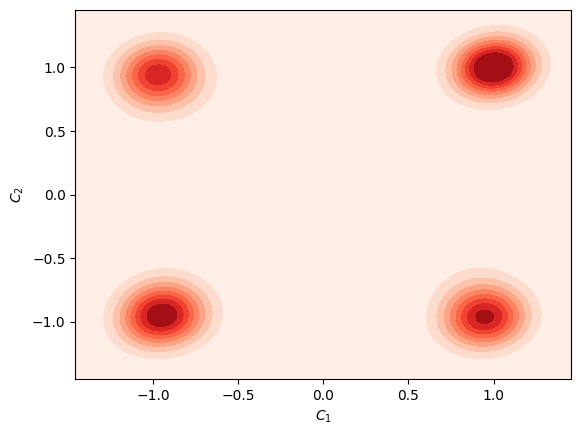

In [86]:
@torch.no_grad()
def sample(model, num_samples,model_kwargs):
    x = torch.randn(num_samples, 2, device=device)
    for i in range(1000):
        t = torch.tensor([999 - i], device=device).repeat(num_samples)
        noise_pred = model(x, t, **model_kwargs)
        t = t[0]
        x = noise_scheduler.step(noise_pred, t, x).prev_sample
    return x

   
y = torch.randint(1,3, (1000,2)).to(device)
y_null = torch.tensor([[0,0]]).repeat(1000,1).to(device)
model_kwargs = {'y':y,'y_null':y_null}
samples = sample(and_model, 1000,model_kwargs)
density_plot(samples.cpu().detach().numpy())
plt.xlabel(r"$C_1$")
plt.ylabel(r"$C_2$")

### Linear Classifier to showcase the model trained with sythetic data will lead to better Worst group accuracy by learning the true decision boundary. This would improve the fairness, other generalization of the downstream classifiers. 

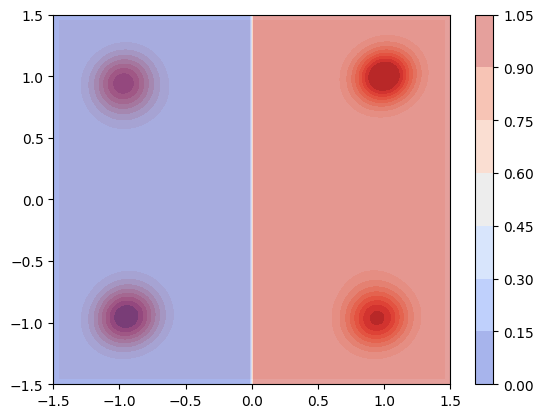

In [87]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim: int = 2, output_dim: int = 2):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x)

epochs = 10000
classifier = LinearClassifier().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
classifier.train()
for i in range(epochs):
    optimizer.zero_grad()
    logits = classifier(samples)
    loss = criterion(logits, y[:,0]-1)
    loss.backward()
    optimizer.step()
    scheduler.step()
def plot_classifier(model):
    x = torch.linspace(-1.5, 1.5, 100)
    y = torch.linspace(-1.5, 1.5, 100)
    X, Y = torch.meshgrid(x, y)
    Z = torch.zeros_like(X)
    for i in range(X.size(0)):
        for j in range(X.size(1)):
            z = torch.tensor([X[i,j], Y[i,j]]).to(device)
            with torch.no_grad():
                logits = model(z)
            Z[i,j] = logits.argmax().item()
    plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), alpha=0.5, cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()

density_plot(samples.cpu().detach().numpy())
plot_classifier(classifier)

## Theoritical Analysis: Incorrect objective of vanilla diffusion models for the for Mixture of Gaussians

In [88]:
import numpy as np
import torch


mus = np.array([[-1,-1], [-1,1], [1,-1],[1,1]])
sigma = np.eye(2)*0.1
def normal_density(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu).T@np.linalg.inv(sigma)@(x - mu))) / (2*np.pi*np.sqrt(np.linalg.det(sigma))), np.linalg.inv(sigma)@(mu-x)


score_11 = lambda x: -np.linalg.inv(sigma)@(x - mus[0].reshape(-1,1))# score P(X|  C_1=1,C_2=1)
score_21 = lambda x: -np.linalg.inv(sigma)@(x - mus[1].reshape(-1,1)) # score P(X| C_1=2,C_2=1)
score_12 = lambda x: -np.linalg.inv(sigma)@(x - mus[2].reshape(-1,1))# score P(X|  C_1=1,C_2=2)


def score_00(x): # score P(X)
    sum_weights = 0
    total_score = 0
    for mu_index in [0,1,2]:
        weight,score = normal_density(x, mus[mu_index].reshape(-1,1), np.eye(2)*0.1)
        sum_weights += weight
        total_score += score*weight
    return total_score/sum_weights


def score_22(x):
    #estimated from the AND composition. 
    return score_21(x) + score_12(x) - score_00(x)

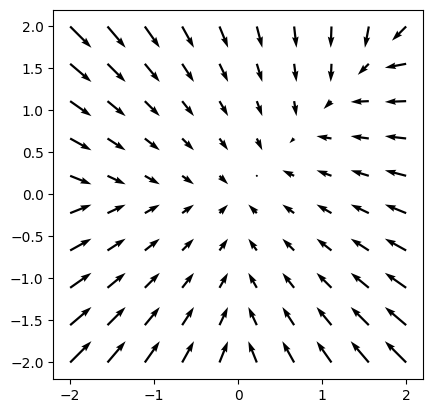

In [89]:
#plot the direction of score as arrows
import matplotlib.pyplot as plt
X = np.linspace(-2,2,10)
Y = np.linspace(-2,2,10)
X,Y = np.meshgrid(X,Y)
U = np.zeros_like(X)
V = np.zeros_like(Y)
norm = np.zeros_like(X)
for i in range(10):
    for j in range(10):
        x = np.array([X[i,j],Y[i,j]]).reshape(-1,1)
        score = and_composition_score(x)
        U[i,j] = score[0][0]
        V[i,j] = score[1][0]
        norm[i,j] = np.linalg.norm(score)

fig, ax = plt.subplots()
ax.quiver(X,Y,U,V)
ax.set_aspect('equal')

### Incorrect score of vanilla Score based model training, where all the arrows pointed to (1,1)

### Once true score is derived we can sampling directly from the score by using Langevin dynamics

In [90]:
def sample(score, num_samples):
    samples = []
    step_size = 0.01 # close to 0
    num_steps = 1000 #close to inf
    for i in range(num_samples):
        x = np.random.randn(2,1)
        for j in range(num_steps):
            score_val = score(x)
            x = x + step_size*score_val + np.random.randn(2,1)*np.sqrt(0.02)
        samples.append(x)
    return np.array(samples)

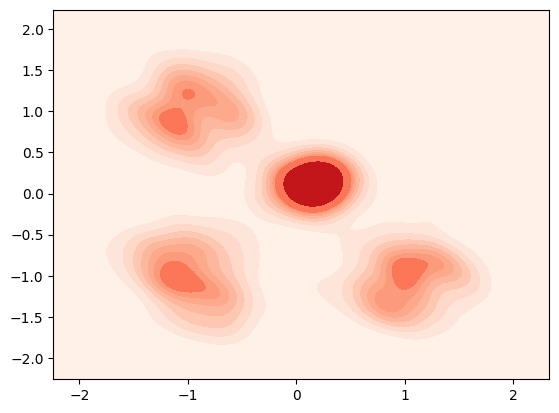

In [91]:
from scipy.stats import multivariate_normal
import seaborn as sns

all_samples = []
for score in [score_11,score_21,score_12,score_22]:
    samples = sample(score, 100)
    all_samples.append(samples)
all_samples = np.concatenate(all_samples,axis=0)

#now plot heatmap of the final_x
sns.kdeplot(x=all_samples[:,0].reshape(-1),y=all_samples[:,1].reshape(-1),cmap="Reds", fill=True, thresh=0, bw_adjust=0.5)
plt.show()


## Incorrect interpolation and will lead to incorrect generation of novel compositions and this errors will be translated to the downstream classifiers trained with these generative models.